In [1232]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

---
<center><h1>Baseline Model 0.0<center><h1>

* [ ] Baseline model will look at the absolute change from year N1 to year N2

In [1233]:
#Load Data

df_X=pd.read_csv('../data/interim/df_X.csv',index_col=0)
df_Y=pd.read_csv('../data/interim/df_Y.csv',index_col=0)

---
<center><h1>Total Change Accross the Years<center><h1>


* [ ] Y: calculate the difference from 2010 to 2021
* [ ] X_num
    * [ ] groupby Census Tract and sum all X_num
* [ ] X_obj
    * [ ] One hot encode where possible, drop the rest
#

---
**<center><h3>X columns preparation<center><h3>**

In [1235]:
#Exclude permit applications after 2022 as there is no dependent variable information after 2011

#Create mask
date_mask=df_X['ISSUE_DATE'].astype('datetime64').dt.year<2022

#apply mask
df_X_temp=df_X[date_mask].reset_index(drop=True)

In [1236]:
#Split into numeric and object columns
df_X_num=df_X_temp.select_dtypes("number")
df_X_obj=df_X_temp.select_dtypes("object")

---
### Categorical Columns

In [1239]:
#Select columns that are appropriate to be OneHotEncoded
df_X_obj_ohe=df_X_obj[['PERMIT_TYPE','REVIEW_TYPE','CONTACT_1_TYPE']]
enc = OneHotEncoder(sparse=False)
X_obj_mod_1=enc.fit_transform(df_X_obj_ohe)

#Generate column names from the one hot encoded array
col_names=['PERMIT_TYPE_'+i for i in enc.categories_[0]]+['REVIEW_TYPE_'+i for i in enc.categories_[1]]+['CONTACT_1_TYPE_'+i for i in enc.categories_[2]]
df_X_obj_mod=pd.DataFrame(X_obj_mod_1,columns=col_names)
pd.concat([df_X_num,df_X_obj_mod],axis=1)

#DATAFRAME CONCAT
#df_X_num+df_X_obj_mo
df_X_mod_1=pd.concat([df_X_num,df_X_obj_mod],axis=1).drop(columns='ID')

print(df_X_mod_1.shape)
df_X_mod_1.head();

(659957, 65)


---
### Numeric Columns

 **GROUPINGS:**
* Testing 2 distinct modes of grouping & aggregating numeric columns
* The independent variable (earnings) has yearly granularity and X_df has to match it 

In [1240]:
#the overall count of applications is likely to be a useful feature
application_count=df_X_mod_1.groupby('Census_Tract').size().sort_index()
df_application_count=pd.DataFrame(application_count,columns=['Total_application_count']).sort_index()
#application_count

*METHOD 1: AGGREGATING ALL THE COLUMNS*

In [1241]:
df_X_mod_1a=pd.concat([df_X_mod_1.groupby('Census_Tract').sum(),df_application_count],axis=1)
df_X_mod_1a.shape

(786, 65)

*METHOD 2: FINDING RATIOS TO THE APPLICATION COUNT FOR EACH COLUMN*

In [1242]:
df_X_mod_1b=df_X_mod_1.groupby('Census_Tract').sum().div(application_count, axis=0)
df_X_mod_1b.shape

(786, 64)

---
**<center><h3>y preparation<center><h3>**

* [ ] Calculate the overall change from 2010 to 2011
* [ ] Find the average change
* [ ] Assign classes basen on being below or above the mean

In [1243]:
df_Y.shape

(702310, 13)

In [1244]:
df_Y=df_Y[date_mask]

In [1399]:
y_mod1=(pd.concat([pd.DataFrame(df_Y['Median_earnings_2021']-df_Y['Median_earnings_2010'],columns=['Earnings_Change']),df_Y['Census_Tract']],axis=1)).groupby('Census_Tract').mean().sort_index()['Earnings_Change']
y_mod1_temp=y_mod1.copy()
y_mod1.describe()

count      786.000000
mean     12483.133588
std      11619.611867
min     -36813.000000
25%       4845.250000
50%      10854.000000
75%      18422.000000
max      66090.000000
Name: Earnings_Change, dtype: float64

In [1246]:
y_filter=y_mod1>y_mod1.median()
y_mod1=[1 if i==True else 0 for i in y_filter]

---
**<center><h3>FURTHER EDA<center><h3>**

In [1393]:
df_model1=pd.concat([df_X_mod_1b.reset_index(drop=False),pd.Series(y_mod1)],axis=1).rename(columns={0:'Gentrification'})
print(df_model1.shape)
df_model1.head()


(786, 66)


,Census_Tract,PROCESSING_TIME,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,SUBTOTAL_UNPAID,...,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,CONTACT_1_TYPE_OWNER OCCUPIED,CONTACT_1_TYPE_PLUMBING CONTRACTOR,CONTACT_1_TYPE_RESIDENTAL REAL ESTATE DEV,CONTACT_1_TYPE_SELF CERT ARCHITECT,CONTACT_1_TYPE_SIGN CONTRACTOR,CONTACT_1_TYPE_STRUCTURAL ENGINEER,CONTACT_1_TYPE_TENT CONTRACTOR,CONTACT_1_TYPE_UNKNOWN,Gentrification
0,10100,33.512711,754.816109,47.040563,32.556291,834.412964,1.854305,0.124172,0.059603,2.038079,...,0.099338,0.034768,0.000000,0.0,0.011589,0.018212,0.031457,0.000000,0.006623,1
1,10201,14.080230,580.062804,47.984813,31.511390,659.559007,0.689252,0.000000,0.613318,1.302570,...,0.079439,0.060748,0.003505,0.0,0.012850,0.025701,0.012850,0.001168,0.004673,0
2,10202,23.675127,521.344036,61.015228,33.444162,615.803426,1.803299,-0.571066,0.571066,1.803299,...,0.068528,0.045685,0.000000,0.0,0.038071,0.078680,0.017766,0.000000,0.010152,0
3,10300,22.811881,556.271980,45.309052,35.623876,637.204908,7.722489,0.106082,0.212164,8.040736,...,0.093352,0.057992,0.001414,0.0,0.008487,0.022631,0.024045,0.014144,0.007072,0
4,10400,24.929742,644.136183,36.206089,87.618267,767.960539,7.143091,0.000000,0.000000,7.143091,...,0.053864,0.053864,0.001171,0.0,0.031616,0.025761,0.005855,0.005855,0.011710,0


In [1404]:
df_model1['Median_Income_Change']=y_mod1_temp.reset_index(drop=True)
df_model1

,Census_Tract,Median_Income_Change,PROCESSING_TIME,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,...,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,CONTACT_1_TYPE_OWNER OCCUPIED,CONTACT_1_TYPE_PLUMBING CONTRACTOR,CONTACT_1_TYPE_RESIDENTAL REAL ESTATE DEV,CONTACT_1_TYPE_SELF CERT ARCHITECT,CONTACT_1_TYPE_SIGN CONTRACTOR,CONTACT_1_TYPE_STRUCTURAL ENGINEER,CONTACT_1_TYPE_TENT CONTRACTOR,CONTACT_1_TYPE_UNKNOWN,Gentrification
0,10100,11198.0,33.512711,754.816109,47.040563,32.556291,834.412964,1.854305,0.124172,0.059603,...,0.099338,0.034768,0.000000,0.0,0.011589,0.018212,0.031457,0.000000,0.006623,1
1,10201,5245.0,14.080230,580.062804,47.984813,31.511390,659.559007,0.689252,0.000000,0.613318,...,0.079439,0.060748,0.003505,0.0,0.012850,0.025701,0.012850,0.001168,0.004673,0
2,10202,229.0,23.675127,521.344036,61.015228,33.444162,615.803426,1.803299,-0.571066,0.571066,...,0.068528,0.045685,0.000000,0.0,0.038071,0.078680,0.017766,0.000000,0.010152,0
3,10300,6293.0,22.811881,556.271980,45.309052,35.623876,637.204908,7.722489,0.106082,0.212164,...,0.093352,0.057992,0.001414,0.0,0.008487,0.022631,0.024045,0.014144,0.007072,0
4,10400,5069.0,24.929742,644.136183,36.206089,87.618267,767.960539,7.143091,0.000000,0.000000,...,0.053864,0.053864,0.001171,0.0,0.031616,0.025761,0.005855,0.005855,0.011710,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,843500,5637.0,24.721191,744.151942,45.523520,14.385432,804.060895,3.931715,0.113809,0.948407,...,0.075873,0.054628,0.006070,0.0,0.013657,0.059181,0.003035,0.048558,0.007587,0
782,843600,17509.0,19.000000,595.487052,61.760917,105.459116,762.707085,1.222707,0.000000,0.118996,...,0.066594,0.050218,0.003275,0.0,0.055677,0.033843,0.019651,0.002183,0.002183,1
783,843700,43982.0,25.948178,769.423292,77.859522,152.815148,1000.097961,2.639522,0.085421,0.683371,...,0.046697,0.048975,0.000569,0.0,0.064920,0.072323,0.008542,0.003986,0.002278,1
784,843800,-6477.0,21.382298,339.257307,39.783427,48.113032,427.153766,1.045198,0.000000,1.224105,...,0.103578,0.067797,0.000000,0.0,0.009416,0.015066,0.005650,0.000000,0.005650,0


In [1405]:
import joblib

joblib.dump(df_model1, '../data/interim/wip/df_model1.pkl')

['../data/interim/wip/df_model1.pkl']

In [1406]:
df_model1=df_model1.drop(columns=['Census_Tract','Median_Income_Chang])

In [1382]:
df_model1

Index(['PROCESSING_TIME', 'BUILDING_FEE_PAID', 'ZONING_FEE_PAID',
       'OTHER_FEE_PAID', 'SUBTOTAL_PAID', 'BUILDING_FEE_UNPAID',
       'ZONING_FEE_UNPAID', 'OTHER_FEE_UNPAID', 'SUBTOTAL_UNPAID',
       'BUILDING_FEE_WAIVED', 'ZONING_FEE_WAIVED', 'OTHER_FEE_WAIVED',
       'SUBTOTAL_WAIVED', 'TOTAL_FEE', 'REPORTED_COST',
       'PERMIT_TYPE_EASY PERMIT PROCESS', 'PERMIT_TYPE_ELECTRIC WIRING',
       'PERMIT_TYPE_ELEVATOR EQUIPMENT', 'PERMIT_TYPE_FOR EXTENSION OF PMT',
       'PERMIT_TYPE_NEW CONSTRUCTION', 'PERMIT_TYPE_PORCH CONSTRUCTION',
       'PERMIT_TYPE_REINSTATE REVOKED PMT',
       'PERMIT_TYPE_RENOVATION/ALTERATION', 'PERMIT_TYPE_SCAFFOLDING',
       'PERMIT_TYPE_SIGNS', 'PERMIT_TYPE_WRECKING/DEMOLITION',
       'REVIEW_TYPE_CONVEYANCE DEVICE PERMIT', 'REVIEW_TYPE_DEMOLITION PERMIT',
       'REVIEW_TYPE_DIRECT DEVELOPER SERVICES', 'REVIEW_TYPE_EASY PERMIT',
       'REVIEW_TYPE_EASY PERMIT WEB', 'REVIEW_TYPE_ELECTRICAL PLAN REVIEW',
       'REVIEW_TYPE_FIRE PROTECTION SYSTEM'

<AxesSubplot:xlabel='Gentrification', ylabel='PERMIT_TYPE_RENOVATION/ALTERATION'>

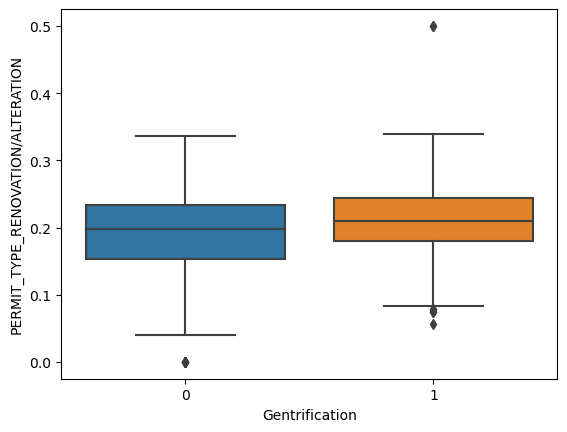

In [1249]:
renovation=df_model1[['Gentrification','PERMIT_TYPE_RENOVATION/ALTERATION']]

sns.boxplot(data=renovation, x='Gentrification', y='PERMIT_TYPE_RENOVATION/ALTERATION')

Text(0.5, 1.0, 'Higher portions of new construction permits lead to faster gentrification')

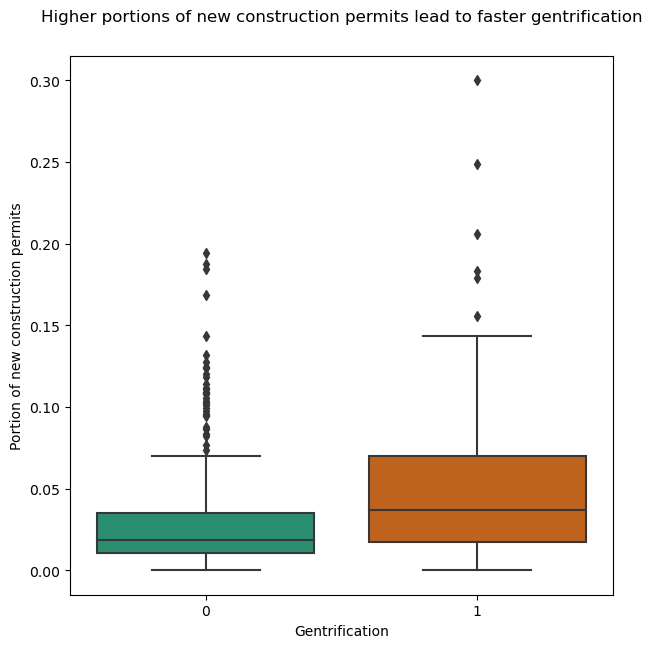

In [1250]:
new_construction=df_model1[['Gentrification','PERMIT_TYPE_NEW CONSTRUCTION']]

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=new_construction, x='Gentrification', y='PERMIT_TYPE_NEW CONSTRUCTION', palette=sns.color_palette('Dark2'))

ax.set_xlabel('Gentrification')
ax.set_ylabel('Portion of new construction permits')
ax.set_title('Higher portions of new construction permits lead to faster gentrification',pad=25)


Text(0.5, 1.0, 'Higher fees paid per permit indicate faster gentrification')

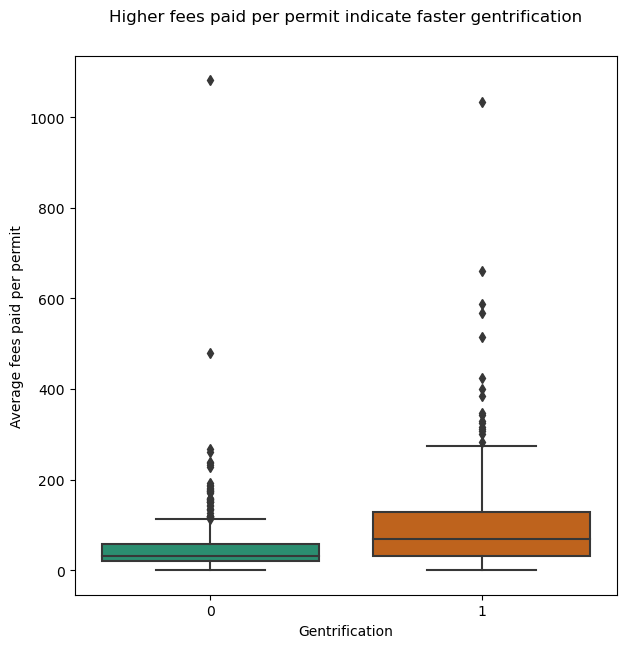

In [1251]:
fees_paid=df_model1[['OTHER_FEE_PAID','Gentrification']]

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=fees_paid, x='Gentrification', y='OTHER_FEE_PAID', palette=sns.color_palette('Dark2'))

ax.set_xlabel('Gentrification')
ax.set_ylabel('Average fees paid per permit')
ax.set_title('Higher fees paid per permit indicate faster gentrification',pad=25)

Text(0.5, 1.0, 'Higher portion of porch contruction permits indicate slower gentrification')

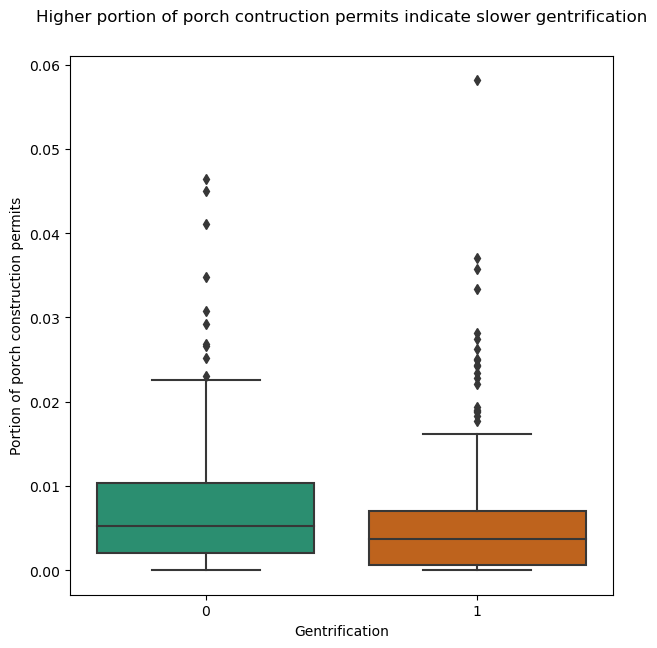

In [1252]:
porch=df_model1[['PERMIT_TYPE_PORCH CONSTRUCTION','Gentrification']]

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=porch, x='Gentrification', y='PERMIT_TYPE_PORCH CONSTRUCTION', palette=sns.color_palette('Dark2'))

ax.set_xlabel('Gentrification')
ax.set_ylabel('Portion of porch construction permits')
ax.set_title('Higher portion of porch contruction permits indicate slower gentrification',pad=25)


---
**<center><h3>MODEL 1.1 & 1.2<center><h3>**

In [1254]:
X1_train,X1_test,y1_train,y1_test=train_test_split(df_X_mod_1a,y_mod1,test_size=0.3,random_state=5)
X2_train,X2_test,y2_train,y2_test=train_test_split(df_X_mod_1b,y_mod1,test_size=0.3,random_state=5)

In [1255]:
scaler1=MinMaxScaler()
scaler1.fit(X1_train)
X1_train_scaled=scaler1.transform(X1_train)
X1_test_scaled=scaler1.transform(X1_test)

scaler2=MinMaxScaler()
scaler2.fit(X2_train)
X2_train_scaled=scaler2.transform(X2_train)
X2_test_scaled=scaler2.transform(X2_test)

In [1256]:
my_logreg1=LogisticRegression(C=10,max_iter=1000,random_state=5)
my_logreg1.fit(X1_train_scaled,y1_train)
print(f'Baseline train accuracy score {my_logreg1.score(X1_train_scaled,y1_train):.3f}%')
print(f'Baseline test accuracy score {my_logreg1.score(X1_test_scaled,y1_test):.3f}%')

Baseline train accuracy score 0.727%
Baseline test accuracy score 0.703%


In [1257]:
my_logreg2=LogisticRegression(C=10,max_iter=1000,random_state=5)
my_logreg2.fit(X2_train_scaled,y2_train)
print(f'Baseline train accuracy score {my_logreg2.score(X2_train_scaled,y2_train):.3f}%')
print(f'Baseline test accuracy score {my_logreg2.score(X2_test_scaled,y2_test):.3f}%')

Baseline train accuracy score 0.729%
Baseline test accuracy score 0.720%


---
**Coefficients: model 0.1**

In [1258]:
pd.DataFrame({'Feature':X1_train.columns,'coeff':my_logreg1.coef_[0]}).sort_values('coeff')[-25:][::-1]

,Feature,coeff
3,OTHER_FEE_PAID,5.035750
51,CONTACT_1_TYPE_MASONRY CONTRACTOR,4.730499
62,CONTACT_1_TYPE_TENT CONTRACTOR,3.582450
19,PERMIT_TYPE_NEW CONSTRUCTION,3.261739
23,PERMIT_TYPE_SCAFFOLDING,3.238864
59,CONTACT_1_TYPE_SELF CERT ARCHITECT,3.145464
33,REVIEW_TYPE_SELF CERT,3.053249
56,CONTACT_1_TYPE_OWNER OCCUPIED,2.582831
2,ZONING_FEE_PAID,2.277643
57,CONTACT_1_TYPE_PLUMBING CONTRACTOR,2.048209


In [1259]:
pd.DataFrame({'Feature':X1_train.columns,'coeff':my_logreg1.coef_[0]}).sort_values('coeff')[:25]

,Feature,coeff
21,PERMIT_TYPE_REINSTATE REVOKED PMT,-3.916885
20,PERMIT_TYPE_PORCH CONSTRUCTION,-2.946174
52,CONTACT_1_TYPE_OWNER,-2.504022
38,CONTACT_1_TYPE_BUILDING OWNER,-2.201786
39,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-1.862005
11,OTHER_FEE_WAIVED,-1.861287
40,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-1.849641
43,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-1.784716
16,PERMIT_TYPE_ELECTRIC WIRING,-1.593177
17,PERMIT_TYPE_ELEVATOR EQUIPMENT,-1.359856


**Coefficients: model 0.2**

In [1260]:
pd.DataFrame({'Feature':X2_train.columns,'coeff':my_logreg2.coef_[0]}).sort_values('coeff')[-25:][::-1]

,Feature,coeff
3,OTHER_FEE_PAID,5.686516
51,CONTACT_1_TYPE_MASONRY CONTRACTOR,2.912529
23,PERMIT_TYPE_SCAFFOLDING,2.766086
62,CONTACT_1_TYPE_TENT CONTRACTOR,2.705759
7,OTHER_FEE_UNPAID,2.661046
6,ZONING_FEE_UNPAID,2.022647
59,CONTACT_1_TYPE_SELF CERT ARCHITECT,2.013024
49,CONTACT_1_TYPE_MASON - BRICK ONLY,1.869509
2,ZONING_FEE_PAID,1.829144
55,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,1.448455


In [1330]:
pd.DataFrame({'Feature':X2_train.columns,'coeff':my_logreg2.coef_[0]}).sort_values('coeff')[:15].reset_index(drop=True)
#[-25:][::-1]

,Feature,coeff
0,PERMIT_TYPE_PORCH CONSTRUCTION,-2.306090
1,PERMIT_TYPE_REINSTATE REVOKED PMT,-2.011493
2,REPORTED_COST,-1.746038
3,BUILDING_FEE_PAID,-1.675023
4,CONTACT_1_TYPE_MASON - CONCRETE ONLY,-1.653386
5,CONTACT_1_TYPE_OWNER,-1.631506
6,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,-1.441356
7,OTHER_FEE_WAIVED,-1.410111
8,REVIEW_TYPE_EASY PERMIT,-1.274121
9,CONTACT_1_TYPE_CONTRACTOR-WRECKING,-1.150205


---
**PCA**

In [1407]:
my_pca=PCA(n_components=5)
X2_pca_train=my_pca.fit_transform(X2_train_scaled)
X2_pca_test=my_pca.transform(X2_test_scaled)

In [1408]:
my_logreg3=LogisticRegression(C=10,max_iter=1000,random_state=1)
my_logreg3.fit(X2_pca_train,y2_train)
print(f'Baseline train accuracy score {my_logreg3.score(X2_pca_train,y2_train):.3f}%')
print(f'Baseline test accuracy score {my_logreg3.score(X2_pca_test,y2_test):.3f}%')

Baseline train accuracy score 0.676%
Baseline test accuracy score 0.699%


---
<center><h3> Baseline KNN <center><h3>

In [1264]:
'''
Train set accuracy: 0.68%
Test set accuracy: 0.64%
''';

In [1265]:
knn = KNeighborsClassifier(n_neighbors=15).fit(X2_train_scaled, y2_train)

train_predictions = knn.predict(X2_train_scaled)
train_accuracy = accuracy_score(train_predictions, y2_train)
print(f"Train set accuracy: {train_accuracy:.2f}%")

test_predictions = knn.predict(X2_test_scaled)
test_accuracy = accuracy_score(test_predictions, y2_test)
print(f"Test set accuracy: {test_accuracy:.2f}%")

Train set accuracy: 0.71%
Test set accuracy: 0.71%


c:\Users\44742\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\44742\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

---
<center><h3>Baseline Decision Tree<center><h3>

In [1266]:
dt_model = DecisionTreeClassifier(max_depth=5).fit(X1_train_scaled, y1_train)
print(f"Train set accuracy: {dt_model.score(X1_train_scaled, y1_train):.2f}%")
print(f"Test set accuracy: {dt_model.score(X1_test_scaled,y1_test):.2f}%")

Train set accuracy: 0.80%
Test set accuracy: 0.63%


In [1267]:
dt_model = DecisionTreeClassifier(max_depth=5).fit(X2_train_scaled, y2_train)
print(f"Train set accuracy: {dt_model.score(X2_train_scaled, y2_train):.2f}%")
print(f"Test set accuracy: {dt_model.score(X2_test_scaled,y2_test):.2f}%")

Train set accuracy: 0.79%
Test set accuracy: 0.71%


In [1268]:
from sklearn.tree import plot_tree

In [1269]:
'''plot_tree(dt_model, 
          feature_names=X2_train_scaled, 
          class_names=["Gentrification", "No Gentrification"],
          rounded=True,
          impurity=False,
          filled=True);'''

'plot_tree(dt_model, \n          feature_names=X2_train_scaled, \n          class_names=["Gentrification", "No Gentrification"],\n          rounded=True,\n          impurity=False,\n          filled=True);'

---
<center><h3>Model 1.1&1.2 Conclusions<center><h3>

* Census Tract data should be analysed with respect to the overall number of applications for each census tract

</br>

</br>

</br>

</br>

---
---
**<center><h3>MODEL 2.0: YEARLY ANALYSIS <center><h3>**

Let's now increase the granularity of the analysis & look at the yearly changes
* **Y**
* [ ] For each census tract calculate the difference between consecutive years
* *Hierarchical Indexing* - [Census Tract], [Year]
</br>
</br>
* **X**
* [ ] Split X-dataframe by year 
* *Hierarchical Indexing* - [Census Tract], [Year]

---
**<center><h3>Y-column<center><h3>**

In [1270]:
#Reverse the column order to list from 2010 to 2021 
df_Y_temp=df_Y.set_index('Census_Tract').iloc[:,::-1]

#df_Y_temp.head(5)
print(f"The current shape of the dependent variable dataframe is {df_Y_temp.shape}")

The current shape of the dependent variable dataframe is (659957, 12)


In [1271]:
df_Y_temp=df_Y_temp.groupby('Census_Tract').mean()
print(df_Y_temp.shape)
unique_tracts=df_Y_temp.shape[0]
print(unique_tracts)

(786, 12)
786


In [1272]:
year=2011

df_Y_loop=pd.DataFrame()
#temporary dataframe

for i in range(len(df_Y_temp.columns)-1):

    #creating a column to calculate the difference between pairs of adjacent column
    df_Y_loop['Earnings_change']=(df_Y_temp.iloc[:,i+1]-df_Y_temp.iloc[:,i]).values
    df_Y_loop['Census_Tract']=df_Y_temp.index
    df_Y_loop['Year']=year

    if year==2011:
        df_Y_model2=df_Y_loop.copy()
    else:
        df_Y_model2=pd.concat([df_Y_model2,df_Y_loop])

    year+=1

In [1273]:
df_Y_temp

,Median_earnings_2010,Median_earnings_2011,Median_earnings_2012,Median_earnings_2013,Median_earnings_2014,Median_earnings_2015,Median_earnings_2016,Median_earnings_2017,Median_earnings_2018,Median_earnings_2019,Median_earnings_2020,Median_earnings_2021
Census_Tract,,,,,,,,,,,,
10100,32631.0,31860.0,30455.0,30795.0,30175.0,30641.0,31107.0,36985.0,38076.0,35985.0,41424.0,43829.0
10201,30931.0,29346.0,29688.0,28564.0,30190.0,32624.0,35058.0,31793.0,33517.0,33388.0,35750.0,36176.0
10202,30136.0,30408.0,27299.0,26417.0,25214.0,27703.0,30192.0,28791.0,30237.0,30104.0,31212.0,30365.0
10300,40259.0,40144.0,36772.0,34898.0,36372.0,35427.5,34483.0,34260.0,35818.0,38230.0,39812.0,46552.0
10400,39303.0,41913.0,38242.0,40688.0,42364.0,41331.0,40298.0,42088.0,40921.0,40333.0,42526.0,44372.0
...,...,...,...,...,...,...,...,...,...,...,...,...
843500,15183.0,13137.0,8889.0,14176.0,16674.0,16550.5,16427.0,16783.0,23971.0,21936.0,18152.0,20820.0
843600,26898.0,29188.0,38547.0,31646.0,33698.0,37038.0,40378.0,41304.0,40801.0,41818.0,42800.0,44407.0
843700,49924.0,54149.0,60449.0,55714.0,54349.0,58021.5,61694.0,61199.0,80298.0,86324.0,93846.0,93906.0


In [1274]:
df_Y_model2=df_Y_model2.groupby(['Census_Tract','Year']).mean()
df_Y_model2

Earnings_change
Census_Tract Year                 
10100        2011           -771.0
             2012          -1405.0
             2013            340.0
             2014           -620.0
             2015            466.0
...                            ...
843900       2017          11664.0
             2018           2863.0
             2019          -3755.0
             2020           5454.0
             2021           2660.0

[8646 rows x 1 columns]

---
**<center><h3>X-columns<center><h3>**

In [1275]:
df_X_mod_2=df_X_mod_1.set_index('Census_Tract')

#add Isuue_Date back to the X dataframe
df_X_mod_2['Year']=df_X_obj['ISSUE_DATE'].astype('datetime64').dt.year.values

#set 'year' column as index
df_X_mod_2=df_X_mod_2.set_index([df_X_mod_2.index,'Year'])

In [1276]:
df_X_mod_2;

***
<center><h3>Model 2.0 : X and Y df<center><h3>

In [1277]:
df_X_mod_2.head(18)

PROCESSING_TIME  BUILDING_FEE_PAID  ZONING_FEE_PAID  \
Census_Tract Year                                                        
10100        2006         0.000000             287.50             75.0   
             2006        70.000000              70.00              0.0   
             2006         0.000000             140.00              0.0   
             2006        21.677212              40.00              0.0   
             2006        62.000000              40.00              0.0   
             2006        44.000000              40.00              0.0   
             2006         6.000000              40.00              0.0   
             2006         1.000000               0.00              0.0   
             2006         0.000000             625.00             50.0   
             2006         0.000000             367.00             75.0   
             2006         0.000000              40.00              0.0   
             2006         0.000000              70.00              0.0   
             2006        10.000000             162.50             75.0   
             2008        93.000000           12588.81            150.0   
             2006         0.000000             171.25             75.0   
             2006         2.000000             415.00             75.0   
             2006         0.000000              40.00              0.0   
             2007        95.000000           23252.50             75.0   

                   OTHER_FEE_PAID  SUBTOTAL_PAID  BUILDING_FEE_UNPAID  \
Census_Tract Year                                                       
10100        2006             0.0         362.50                  0.0   
             2006             0.0          70.00                  0.0   
             2006             0.0         140.00                500.0   
             2006             0.0          40.00                  0.0   
             2006             0.0          40.00                  0.0   
             2006             0.0          40.00                  0.0   
             2006             0.0          40.00                  0.0   
             2006             0.0           0.00                  0.0   
             2006             0.0         675.00                  0.0   
             2006             0.0         442.00                  0.0   
             2006             0.0          40.00                  0.0   
             2006             0.0          70.00                  0.0   
             2006             0.0         237.50                  0.0   
             2008             0.0       12738.81                  0.0   
             2006             0.0         246.25                  0.0   
             2006             0.0         490.00                  0.0   
             2006            50.0          90.00                  0.0   
             2007             0.0       23327.50                  0.0   

                   ZONING_FEE_UNPAID  OTHER_FEE_UNPAID  SUBTOTAL_UNPAID  \
Census_Tract Year                                                         
10100        2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0            500.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006                0.0               0.0              0.0   
             2006          

In [1278]:
df_Y_model2.head(18)

Earnings_change
Census_Tract Year                 
10100        2011           -771.0
             2012          -1405.0
             2013            340.0
             2014           -620.0
             2015            466.0
             2016            466.0
             2017           5878.0
             2018           1091.0
             2019          -2091.0
             2020           5439.0
             2021           2405.0
10201        2011          -1585.0
             2012            342.0
             2013          -1124.0
             2014           1626.0
             2015           2434.0
             2016           2434.0
             2017          -3265.0

***
### Model 2: Approach A
* Look at each year separately & attempt to determine the time lag between the permit data and the change in earnings
* Regression time series

In [1279]:
df_X_mod_2a=df_X_mod_2.groupby(['Census_Tract','Year']).mean()
df_X_mod_2a.head(18)

PROCESSING_TIME  BUILDING_FEE_PAID  ZONING_FEE_PAID  \
Census_Tract Year                                                        
10100        2006        18.881716        1398.327778        37.777778   
             2007       143.816667        1655.281000        46.666667   
             2008        43.516129        1987.376452        54.838710   
             2009        69.000000         258.618261        45.108696   
             2010        11.812500         386.102188        44.531250   
             2011         5.214286         357.765714        46.428571   
             2012         9.115385         632.278846        28.846154   
             2013        23.177778         171.858667        46.111111   
             2014        10.763636         214.606182        33.636364   
             2015        12.166667         355.115667        27.500000   
             2016         6.035714        1066.071429       137.053571   
             2017         2.060606         374.090909        47.727273   
             2018        19.640000         789.440000        39.000000   
             2019        11.304348         543.928261        73.913043   
             2020        43.552632         880.470526        32.894737   
             2021        16.000000         854.172778        24.305556   
10201        2006        31.036364        3278.972727        35.000000   
             2007        55.000000        1212.216346        53.365385   

                   OTHER_FEE_PAID  SUBTOTAL_PAID  BUILDING_FEE_UNPAID  \
Census_Tract Year                                                       
10100        2006      132.711111    1568.816667            11.111111   
             2007       17.083333    1719.031000             0.000000   
             2008       40.322581    2082.537742             0.000000   
             2009        1.086957     304.813913             0.000000   
             2010       53.156250     483.789688             0.000000   
             2011      115.250000     519.444286             0.000000   
             2012       20.192308     681.317308             0.000000   
             2013        2.222222     220.192000             0.000000   
             2014        0.909091     249.151636             1.909091   
             2015       10.000000     392.615667             0.000000   
             2016        3.571429    1206.696429            10.892857   
             2017        0.000000     421.818182             0.000000   
             2018        0.000000     828.440000             0.000000   
             2019       68.043478     685.884783             4.565217   
             2020       17.342105     930.707368             0.000000   
             2021       43.750000     922.228333             0.000000   
10201        2006       54.681818    3368.654545             0.000000   
             2007       49.057692    1314.639423             0.000000   

                   ZONING_FEE_UNPAID  OTHER_FEE_UNPAID  SUBTOTAL_UNPAID  \
Census_Tract Year                                                         
10100        2006           0.000000          0.000000        11.111111   
             2007           0.000000          0.000000         0.000000   
             2008           0.000000          0.000000         0.000000   
             2009           0.000000          0.000000         0.000000   
             2010           0.000000          0.000000         0.000000   
             2011           0.000000          0.000000         0.000000   
             2012           0.000000          0.000000         0.000000   
             2013           0.000000          0.000000         0.000000   
             2014           0.000000          0.000000         1.909091   
             2015           0.000000          0.000000         0.000000   
             2016           2.678571          1.214286        14.785714   
             2017           0.000000          0.000000         0.000000   
             2018          

***
### Model 2: Approach B
* [ ] Look at 5 year cummulatives for permits

In [1280]:
df_Y_model2.head(11)

#list of years
year_edu=[i[1] for i in df_Y_model2.index]

#distinct years
print('Number of distinct years in the education dataset =',len(set(year_edu)))

df_Y_model2.head(11)

Number of distinct years in the education dataset = 11


Earnings_change
Census_Tract Year                 
10100        2011           -771.0
             2012          -1405.0
             2013            340.0
             2014           -620.0
             2015            466.0
             2016            466.0
             2017           5878.0
             2018           1091.0
             2019          -2091.0
             2020           5439.0
             2021           2405.0

In [1281]:
print('The media is',df_Y_model2.median())
df_Y_model2.describe()

The media is Earnings_change    887.5
dtype: float64


,Earnings_change
count,8646.000000
mean,1134.830326
std,3932.596767
min,-38657.000000
25%,-685.125000
50%,887.500000
75%,2934.750000
max,40125.000000


In [1282]:
df_X_mod2;

In [1283]:
#select year from the index & store in a list
year_li=[i[1] for i in df_X_mod_2.index]

year_distinct=sorted(list(set(year_li)))
print(len(year_distinct))

year_groups=[]
for i in range(1,len(year_distinct)-4):
    #print(year_distinct[i:i+5])
    year_groups.append(year_distinct[i:i+5])

print(len(year_groups))
year_groups

16
11


[[2007, 2008, 2009, 2010, 2011],
 [2008, 2009, 2010, 2011, 2012],
 [2009, 2010, 2011, 2012, 2013],
 [2010, 2011, 2012, 2013, 2014],
 [2011, 2012, 2013, 2014, 2015],
 [2012, 2013, 2014, 2015, 2016],
 [2013, 2014, 2015, 2016, 2017],
 [2014, 2015, 2016, 2017, 2018],
 [2015, 2016, 2017, 2018, 2019],
 [2016, 2017, 2018, 2019, 2020],
 [2017, 2018, 2019, 2020, 2021]]

In [1284]:
#Dictionary of maps to filter by belonging to each of the 5 year frames
mask_di={}
year=2011
for i in range(len(year_groups)):
    mask_di[year]=[(k in year_groups[i]) for k in year_li]
    year+=1

#sample to check
mask_di[2011][:100:10]

[False, False, False, True, True, True, True, True, True, True]

In [1285]:
df_X_loop=pd.DataFrame()
#temporary dataframe

for k,v in mask_di.items():
    #loop through each dictionary key
    #apply the filter & calculate the means for all columns
    #add the year column (starting from 2011 up to 2021)
    #concat into final df for each loop

    df_X_loop=df_X_mod_2[v].groupby('Census_Tract').mean()
    df_X_loop['Year']=k

    if k==2011:
        df_X_model_2b=df_X_loop.copy()
    else:
        df_X_model_2b=pd.concat([df_X_model2_b,df_X_loop])

        

df_X_model_2b=df_X_model_2b.reset_index().groupby(['Census_Tract','Year']).mean()


In [1296]:
#X_df is smaller because not all census tracts had applications every year
#need to drop them from y
len(set(df_X_model_2b.index).symmetric_difference(set(df_Y_model2.index)))

201

In [1293]:
mask=[df_Y_model2.index[i] in set(df_X_model_2b.index) for i in range(len(df_Y_model2.index))]

len(df_Y_model2.index)

8646

In [1300]:
df_Y_model2=df_Y_model2[mask]

In [1301]:
df_X_model_2b

PROCESSING_TIME  BUILDING_FEE_PAID  ZONING_FEE_PAID  \
Census_Tract Year                                                        
10100        2011        69.421320         990.835939        47.208122   
             2012        32.417178         689.061779        44.478528   
             2013        28.124294         330.181017        43.079096   
             2014        12.881720         313.703978        39.784946   
             2015        12.951087         307.864891        36.956522   
...                            ...                ...              ...   
843900       2017        10.139423         707.033510        48.076923   
             2018         9.250000         893.815000        49.174528   
             2019         7.507177         884.633445        62.559809   
             2020         8.666667         977.605689        59.111111   
             2021        11.301724         922.730259        54.094828   

                   OTHER_FEE_PAID  SUBTOTAL_PAID  BUILDING_FEE_UNPAID  \
Census_Tract Year                                                       
10100        2011       36.817259    1074.861320             0.000000   
             2012       41.429448     774.969755             0.000000   
             2013       31.655367     404.915480             0.000000   
             2014       30.123656     383.612581             0.564516   
             2015       22.836957     367.658370             0.570652   
...                           ...            ...                  ...   
843900       2017       46.778846     801.889279             3.149038   
             2018      148.103774    1091.093302             2.594340   
             2019      138.277512    1085.470766             2.631579   
             2020      133.133333    1169.850133             2.444444   
             2021      123.728448    1100.553534            27.234483   

                   ZONING_FEE_UNPAID  OTHER_FEE_UNPAID  SUBTOTAL_UNPAID  \
Census_Tract Year                                                         
10100        2011           0.000000               0.0         0.000000   
             2012           0.000000               0.0         0.000000   
             2013           0.000000               0.0         0.000000   
             2014           0.000000               0.0         0.564516   
             2015           0.000000               0.0         0.570652   
...                              ...               ...              ...   
843900       2017           0.360577               0.0         3.509615   
             2018           0.353774               0.0         2.948113   
             2019           0.000000               0.0         2.631579   
             2020           0.000000               0.0         2.444444   
             2021           0.000000               0.0        27.234483   

                   BUILDING_FEE_WAIVED  ...  \
Census_Tract Year                       ...   
10100        2011            11.118629  ...   
             2012             6.351963  ...   
             2013             3.420169  ...   
             2014             0.279570  ...   
             2015             0.282609  ...   
...                                ...  ...   
843900       2017             6.380769  ...   
             2018             6.260377  ...   
             2019             3.229665  ...   
             2020             3.000000  ...   
             2021             4.202586  ...   

                   CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR  \
Census_Tract Year                                                  
10100        2011                                            0.0   
             2012                                            0.0   
             2013                                            0.0   
             2014                                            0.0   
             2015                                            0.0   
...                                       

In [1302]:
df_Y_model2.reset_index().groupby('Year').transform('median')['Earnings_change']
#.rename(columns={'Earnings_change':'Year Average'})

0        477.0
1        172.5
2        -37.0
3        423.0
4        736.0
         ...  
8440    1126.0
8441    1620.0
8442    1522.0
8443    1619.0
8444    2613.0
Name: Earnings_change, Length: 8445, dtype: float64

In [1303]:
df_Y_model_temp=pd.concat([df_Y_model2.reset_index(),df_Y_model2.reset_index().groupby('Year').transform('mean')['Earnings_change'].rename('Year_avg',inplace=True)],axis=1)

In [1304]:
df_Y_model_temp.shape

(8445, 4)

In [1305]:
df_Y_model_temp['Earnings_class']=df_Y_model_temp.apply(lambda row: 1 if row['Earnings_change']>row['Year_avg'] else 0, axis=1)

In [1321]:
y_model_2b=df_Y_model_temp.set_index(['Census_Tract','Year'])['Earnings_class']

In [1307]:
print('Average Median Income Change for Each Year')
df_Y_model2.groupby('Year').mean()

Average Median Income Change for Each Year


,Earnings_change
Year,
2011,686.664942
2012,188.363402
2013,-175.852673
2014,352.585398
2015,775.985658
2016,777.549479
2017,1331.986911
2018,2037.181937
2019,1912.673657


Text(0.5, 1.0, 'The Median Income Data Contains Many Outliers')

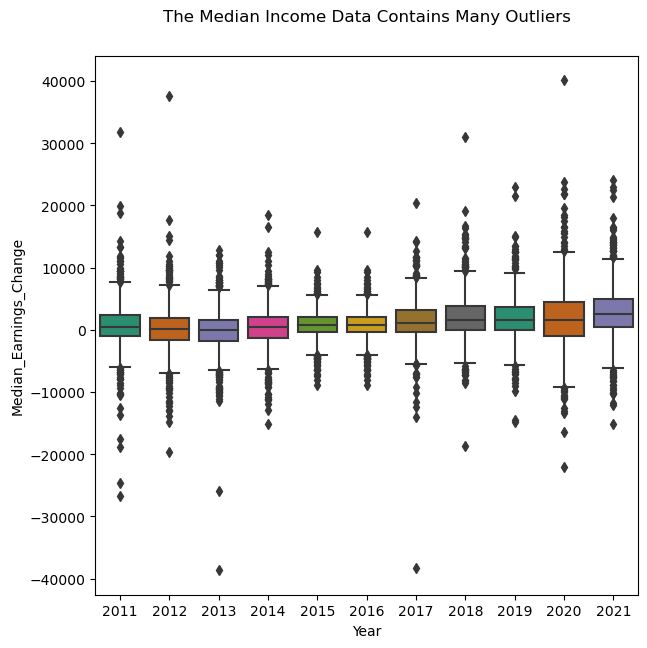

In [1308]:
data_temp=df_Y_model2.reset_index().drop(columns='Census_Tract')

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=data_temp, x='Year', y='Earnings_change', palette=sns.color_palette('Dark2'))

ax.set_xlabel('Year')
ax.set_ylabel('Median_Earnings_Change')
ax.set_title('The Median Income Data Contains Many Outliers',pad=25)

In [1309]:
print(y_model_2b.shape)
print(df_X_model_2b.shape)

(8445, 1)
(8445, 64)


***
<center><h3>Scaling<center><h3>

In [1322]:
X2b_train,X2b_test,y2b_train,y2b_test=train_test_split(df_X_model_2b,y_model_2b,test_size=0.3,random_state=5)

scaler_2b=StandardScaler()
scaler_2b.fit(X2b_train)
X2b_train_scaled=scaler_2b.transform(X2b_train)
X2b_test_scaled=scaler_2b.transform(X2b_test)

In [1326]:
my_logreg_2b=LogisticRegression(C=7,max_iter=1000,random_state=5)
my_logreg_2b.fit(X2b_train_scaled,y2b_train)

print(f'Baseline train accuracy score {my_logreg_2b.score(X2b_train_scaled,y2b_train):.3f}%')
print(f'Baseline test accuracy score {my_logreg_2b.score(X2b_test_scaled,y2b_test):.3f}%')

Baseline train accuracy score 0.579%
Baseline test accuracy score 0.561%


In [1345]:
neg_indc=pd.DataFrame({'Feature':X2b_train.columns,'coeff':my_logreg_2b.coef_[0]}).sort_values('coeff')[:10].reset_index(drop=True)
neg_indc

,Feature,coeff
0,REVIEW_TYPE_STANDARD PLAN REVIEW,-1.263100
1,PERMIT_TYPE_ELECTRIC WIRING,-0.684478
2,CONTACT_1_TYPE_CONTRACTOR-WRECKING,-0.542133
3,PERMIT_TYPE_EASY PERMIT PROCESS,-0.518362
4,REVIEW_TYPE_SELF CERT,-0.512516
5,REVIEW_TYPE_TRADITIONAL DEVELOPER SERVICES,-0.321301
6,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-0.130500
7,CONTACT_1_TYPE_RESIDENTAL REAL ESTATE DEV,-0.104048
8,PERMIT_TYPE_SCAFFOLDING,-0.094129
9,REVIEW_TYPE_DIRECT DEVELOPER SERVICES,-0.088809


In [1346]:
pos_indc=pd.DataFrame({'Feature':X2b_train.columns,'coeff':my_logreg_2b.coef_[0]}).sort_values('coeff')[:-10:-1].reset_index(drop=True)
pos_indc

,Feature,coeff
0,PERMIT_TYPE_RENOVATION/ALTERATION,1.176066
1,PERMIT_TYPE_NEW CONSTRUCTION,0.719829
2,REVIEW_TYPE_EASY PERMIT WEB,0.628379
3,REVIEW_TYPE_EASY PERMIT,0.292526
4,REVIEW_TYPE_DEMOLITION PERMIT,0.290941
5,PERMIT_TYPE_WRECKING/DEMOLITION,0.290941
6,REVIEW_TYPE_FIRE PROTECTION SYSTEM,0.152970
7,CONTACT_1_TYPE_ARCHITECT,0.141184
8,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,0.100340


<AxesSubplot:xlabel='coeff', ylabel='Feature'>

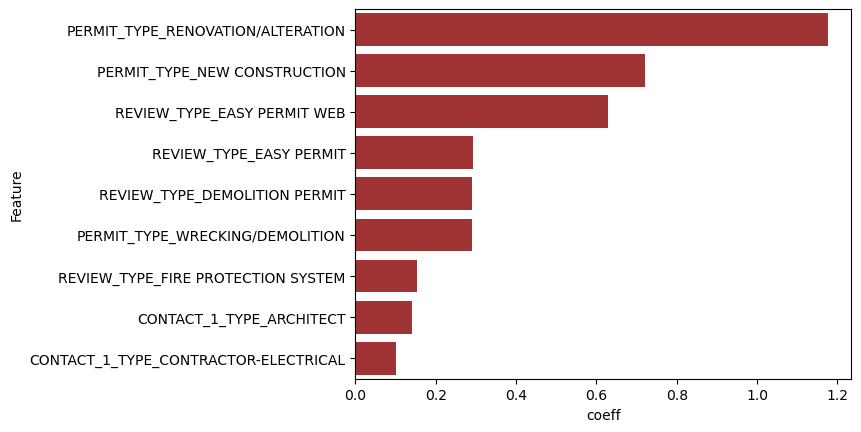

In [1375]:
sns.barplot(data=pos_indc,y='Feature', x="coeff",color='firebrick',orient='h')

<AxesSubplot:xlabel='coeff', ylabel='Feature'>

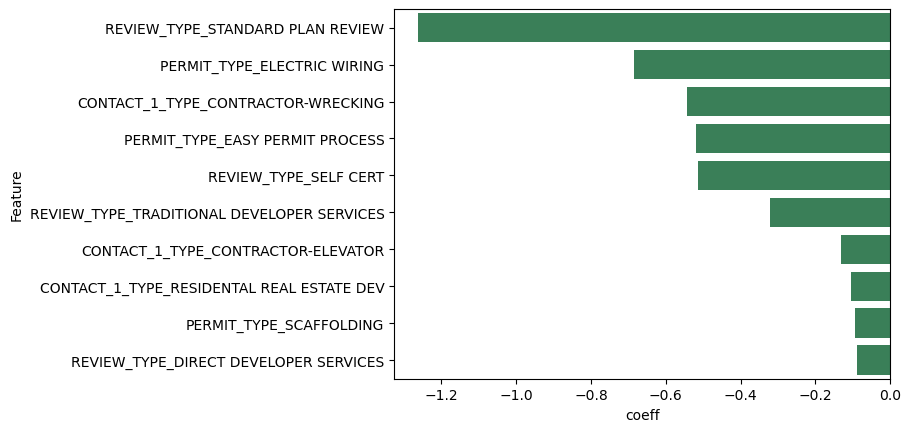

In [1377]:
sns.barplot(data=neg_indc,y='Feature', x="coeff",color='seagreen',orient='h')

In [1327]:
dt_model = DecisionTreeClassifier(max_depth=5).fit(X2b_train_scaled, y2b_train)
print(f"Train set accuracy: {dt_model.score(X2b_train_scaled, y2b_train):.2f}%")
print(f"Test set accuracy: {dt_model.score(X2b_test_scaled,y2b_test):.2f}%")

Train set accuracy: 0.60%
Test set accuracy: 0.56%


In [1320]:
knn = KNeighborsClassifier(n_neighbors=15).fit(X2b_train_scaled, y2b_train)

train_predictions = knn.predict(X2b_train_scaled)
train_accuracy = accuracy_score(train_predictions, y2b_train)
print(f"Train set accuracy: {train_accuracy:.2f}%")

test_predictions = knn.predict(X2b_test_scaled)
test_accuracy = accuracy_score(test_predictions, y2b_test)
print(f"Test set accuracy: {test_accuracy:.2f}%")

c:\Users\44742\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\44742\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Train set accuracy: 0.63%
Test set accuracy: 0.54%


c:\Users\44742\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
